In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import imageio
# import moviepy.editor as mp
# import ffmpy

import os
from math import * 
os.getcwd()
print("The current directory is: ")
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
if path_parent.endswith("Abaqus-Nanoindentation-Project"):
    os.chdir(path_parent) 
    print("Moving up to the parent directory")
    print(os.getcwd())

The current directory is: 
c:\Users\springnuance\Desktop\Abaqus-Nanoindentation-Project\notebooks
Moving up to the parent directory
c:\Users\springnuance\Desktop\Abaqus-Nanoindentation-Project


### Plotting the nanoindentation experiment force-displacement curve

In [2]:
grains = ["1441","2744","3198"]
strainRates = ["0p1","1","100"]
CPLaw = "PH"
material = "ferrite_n100"

# The project path folder
projectPath = os.getcwd()

# The logging path
logPath = f"log/{CPLaw}_{material}.txt"
# The paramInfo path
paramInfoPath = f"paramInfo/{CPLaw}_{material}"
# The results path
resultPath = f"results/{CPLaw}_{material}"
# The simulations path
simPath = f"simulations/{CPLaw}_{material}"
# The target path
targetPath = f"targets/{CPLaw}_{material}"
# The templates path
templatePath = f"templates/{CPLaw}_{material}"

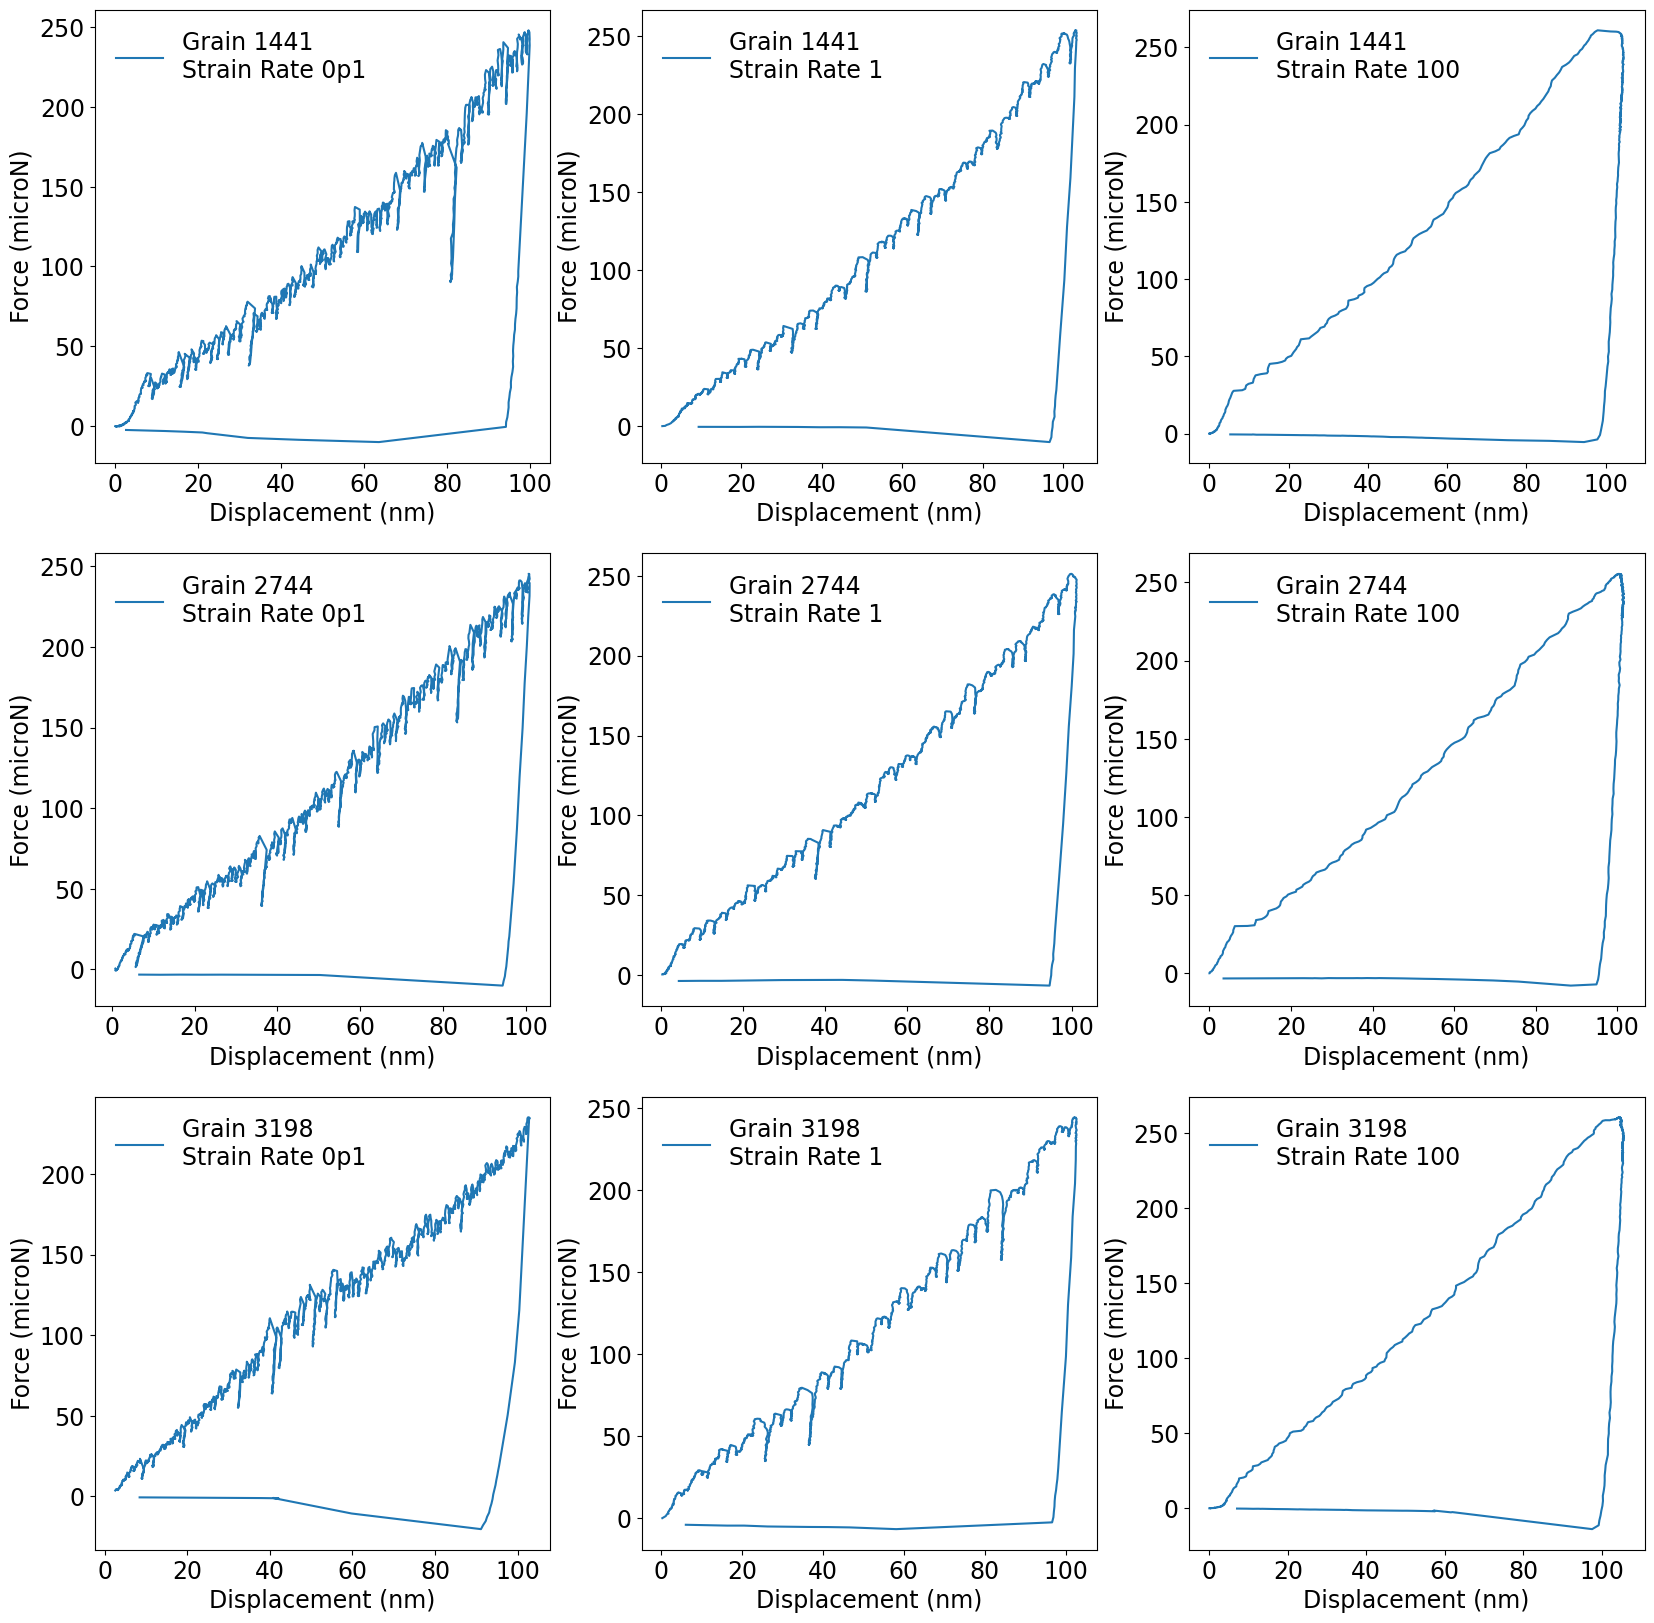

In [9]:
# plot 3 x3 subplots
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

fontsize = 17
for index_grain, grain in enumerate(grains):
    for index_sr, strainRate in enumerate(strainRates):
        # Load the data
        # print(grain)
        data = pd.read_excel(f"{targetPath}/grain_{grain}_sr_{strainRate}/FD_Curve.xlsx", engine='openpyxl')
        
        force = data["force/microN"]
        displacement = data["displacement/nm"]

        ax[index_grain][index_sr].plot(displacement, force, label=f"Grain {grain}\nStrain Rate {strainRate}")
        ax[index_grain][index_sr].set_xlabel("Displacement (nm)", fontsize=fontsize)
        ax[index_grain][index_sr].set_ylabel("Force (microN)", fontsize=fontsize)
        # set xticks an yticks font
        ax[index_grain][index_sr].tick_params(axis='both', which='major', labelsize=fontsize)
        ax[index_grain][index_sr].tick_params(axis='both', which='minor', labelsize=fontsize)
        ax[index_grain][index_sr].legend(fontsize=fontsize, frameon=False)

### How do stop function work? 

In [13]:
def weiszfeld_algorithm(points, tolerance=1e-10):
    """
    Find the geometric median for a set of points using the Weiszfeld algorithm.
    
    :param points: A numpy array of points of shape (N, dimensions).
    :param tolerance: The tolerance to determine convergence.
    :return: The geometric median.
    """
    # Initialize the estimate to the centroid
    estimate = np.mean(points, axis=0)
    
    while True:
        distances = np.sqrt(np.sum((points - estimate)**2, axis=1))
        # Avoid division by zero for points very close to the estimate
        distances = np.maximum(distances, tolerance)
        weights = 1 / distances
        new_estimate = np.sum(points * weights[:, np.newaxis], axis=0) / weights.sum()
        
        # Check for convergence
        if np.linalg.norm(new_estimate - estimate) < tolerance:
            break
        estimate = new_estimate
    
    return estimate

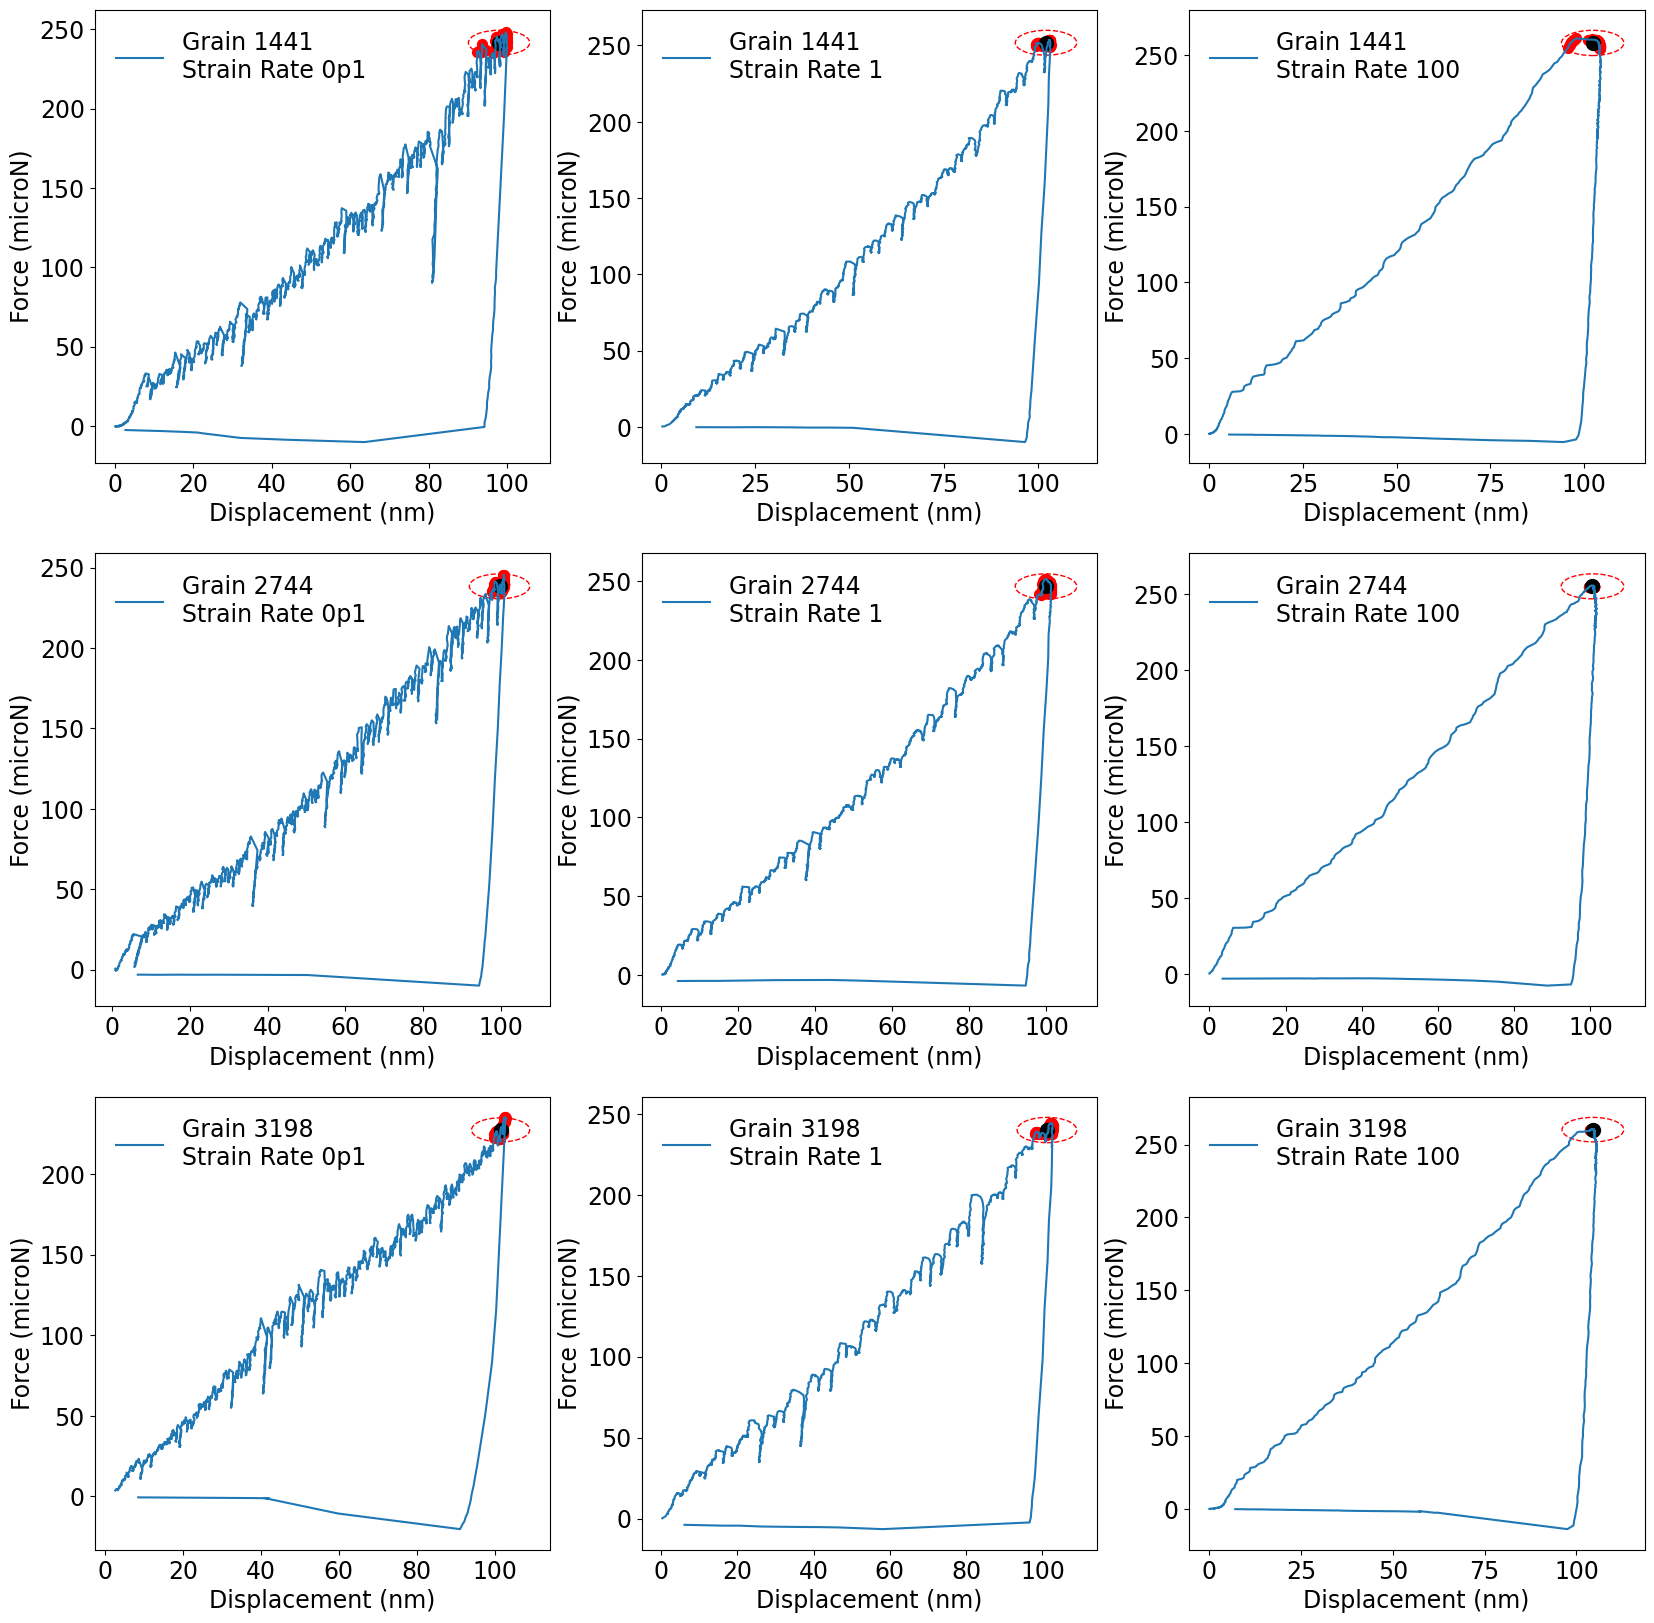

In [20]:
from matplotlib.patches import Circle

# plot 3 x3 subplots
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

fontsize = 17
for index_grain, grain in enumerate(grains):
    for index_sr, strainRate in enumerate(strainRates):
        # Load the data
        # print(grain)
        data = pd.read_excel(f"{targetPath}/grain_{grain}_sr_{strainRate}/FD_Curve.xlsx", engine='openpyxl')
        
        force = data["force/microN"]
        displacement = data["displacement/nm"]

        ax[index_grain][index_sr].plot(displacement, force, label=f"Grain {grain}\nStrain Rate {strainRate}")
        ax[index_grain][index_sr].set_xlabel("Displacement (nm)", fontsize=fontsize)
        ax[index_grain][index_sr].set_ylabel("Force (microN)", fontsize=fontsize)
        # set xticks an yticks font
        ax[index_grain][index_sr].tick_params(axis='both', which='major', labelsize=fontsize)
        ax[index_grain][index_sr].tick_params(axis='both', which='minor', labelsize=fontsize)
        ax[index_grain][index_sr].legend(fontsize=fontsize, frameon=False)

        # picking N points with largest force, and their corresponding displacement
        n = 50
        # get the indices of the n largest values
        indices = np.argpartition(force.to_numpy(), -n)[-n:]
        # get the corresponding displacement
        largest_displacement = displacement[indices]
        largest_force = force[indices]
        ax[index_grain][index_sr].scatter(largest_displacement, largest_force, color='red', s=50)

        # find the center of the largest points

        # Exact center of the N largest points
        # center = weiszfeld_algorithm(np.array([largest_displacement, largest_force]).T)

        # Taking the mean is a good approximation for the center
        x_center, y_center = np.mean(largest_displacement), np.mean(largest_force)
        
        ax[index_grain][index_sr].scatter(x_center, y_center, color='black', s=100)

        deviationPercent = 0.03
        radius = np.sqrt((x_center) ** 2 + (y_center) ** 2) * deviationPercent

        circle = Circle((x_center, y_center), radius, color='red', fill=False, linestyle='--')
        ax[index_grain][index_sr].add_patch(circle)

If the simulation highest point lies within the red circle, 

then the simulation is considered to be accepted. Otherwise, it is a bad fit.

This is the stop function for all the simulations for each experiment data